# LSTM_classifier_with_multiple_embeddings(onehot)
---
### You Li & Zhuowen Lin

Requirements:\
pandas==1.0.5\
numpy==1.19.0\
pretty_midi==0.2.9\
torch==1.5.1+cu101\
matplotlib==3.2.2\
PyYAML==5.3.1\
rich==3.2.0\
scikit_learn==0.23.1\


In [11]:
import glob
import numpy as np
import pandas as pd
from music21 import midi,note,pitch,interval
import sklearn.utils
from sklearn import preprocessing,metrics

In [12]:
from zipfile import ZipFile

file_name = "You_Li_NYU_Zhuowen_Lin_GATech_data-1000.zip"
with ZipFile(file_name,'r') as myzip:
    ZipFile.extractall(myzip)

## Data preperation

In [13]:
def setKeys(midiStream):
    key = midiStream.analyze('key')
    #The pitch of the tone of the original key
    originPitch = pitch.Pitch(key.tonic)
    #set target key
    if key.mode == "major":
        targetPitch = pitch.Pitch('C')
        pitchInterval = interval.notesToChromatic(originPitch,targetPitch).semitones
        if pitchInterval > 6:
            pitchInterval = pitchInterval-12
        elif pitchInterval < -6:
            pitchInterval = pitchInterval+12
        if key.tonic != "C":
            midiStream.transpose(pitchInterval ,inPlace=True)
    elif key.mode == "minor":
        targetPitch = pitch.Pitch('A')
        pitchInterval = interval.notesToChromatic(originPitch,targetPitch).semitones
        if pitchInterval > 6:
            pitchInterval = pitchInterval-12
        elif pitchInterval < -6:
            pitchInterval = pitchInterval+12
        if key.tonic != "A":
            midiStream.transpose(pitchInterval ,inPlace=True)
    return midiStream

In [14]:
def folder_list(path,label=None):
    midifile_path = glob.glob(path)
    midifile_path.sort(key= str.lower)
    melody_list = []
    for f in midifile_path:
        midifile = midi.translate.midiFilePathToStream(f)
        midifile = setKeys(midifile)
        notes = list(midifile.flat.getElementsByClass(classFilterList=[note.Note]))
        if label is not None:
            melody = [[str(m.pitch),
                       str(m.offset%4),
                       str(m.duration.quarterLength),
                       label] for m in notes]
        else:
            melody = [[str(m.pitch),
                       str(m.offset%4),
                       str(m.duration.quarterLength)] for m in notes]
        melody_list.append(melody)
    return melody_list

In [15]:
# Parse sequence
data = (folder_list("/content/data-1000/train/fake/*.mid",0) + 
        folder_list("/content/data-1000/train/real/*.mid",1))
test = folder_list("/content/data-1000/test/*.mid")

In [16]:
# Suffle training data
data_shuffled = sklearn.utils.shuffle(data,random_state=17)
val_sep = int(len(data_shuffled)*0.6)
train = data_shuffled[:val_sep]
val = data_shuffled[val_sep:]

In [17]:
# constuct dictionary
note_dict = set()
beat_dict = set()
dur_dict = set()
for line in train:
    line = np.asarray(line)
    for note in line[:,0]:
        if note not in note_dict:
            note_dict.add(note)
    for beat in line[:,1]:
        if beat not in beat_dict:
            beat_dict.add(beat)
    for duration in line[:,2]:
        if duration not in dur_dict:
            dur_dict.add(duration)

In [18]:
maxlen = max([len(line) for line in train])


X_train = np.zeros((len(train), maxlen, 
                    len(note_dict)+len(beat_dict)+len(dur_dict)),dtype='float32')
                    
X_val = np.zeros((len(val),maxlen,
                  len(note_dict)+len(beat_dict)+len(dur_dict)),dtype='float32')
                
y_train = np.zeros(len(train))
y_val = np.zeros(len(val))

note_index = dict([(n, i) for i, n in enumerate(list(note_dict))])
beat_index = dict([(n, i) for i, n in enumerate(list(beat_dict))])
dur_index = dict([(n, i) for i, n in enumerate(list(dur_dict))])
# One-hot encoding
for j,l in enumerate(train):
    for i, n in enumerate(l):
        X_train[j, i, note_index[n[0]]] = 1.
        X_train[j, i, len(note_dict)+beat_index[n[1]]] = 1.
        X_train[j, i, len(note_dict)+len(beat_dict)+dur_index[n[2]]] = 1.
        y_train[j] = n[-1]

for j,l in enumerate(val):
    for i, n in enumerate(l):
        if i < maxlen:
            if n[0] in note_dict:
                X_val[j, i, note_index[n[0]]] = 1.
            if n[1] in beat_dict:
                X_val[j, i, len(note_dict)+beat_index[n[1]]] = 1.
            if n[2] in dur_dict:
                X_val[j, i, len(note_dict)+len(beat_dict)+dur_index[n[2]]] = 1.
            y_val[j] = n[-1]


## Construction Model

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2

In [20]:
ipt = Input(shape=(None,len(note_dict)+len(beat_dict)+len(dur_dict)),name="Input")
out0 = Bidirectional(LSTM(64,activity_regularizer=l2(0.001),
            # recurrent_dropout=0.2,
            return_sequences=True,name="LSTM0"))(ipt)
out0 = Dropout(0.4,name="Dropout0")(out0)
out0 = Bidirectional(LSTM(8,name="LSTM1"))(out0)
out0 = Dropout(0.4,name="Dropout1")(out0)
fc_out = Dense(1, activation='sigmoid',name="Dense")(out0)

model = Model(inputs=ipt, outputs=[fc_out])

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, None, 154)]       0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         112128    
_________________________________________________________________
Dropout0 (Dropout)           (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                8768      
_________________________________________________________________
Dropout1 (Dropout)           (None, 16)                0         
_________________________________________________________________
Dense (Dense)                (None, 1)                 17        
Total params: 120,913
Trainable params: 120,913
Non-trainable params: 0
________________________________________________

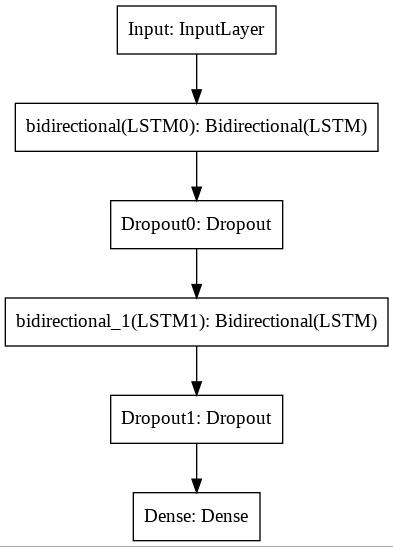

In [22]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model,model_to_dot

SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=model, show_shapes=False,
    to_file='model.jpg'
)

In [23]:
RMSprop = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-7, decay=0.0)
model.compile(optimizer=RMSprop, loss='binary_crossentropy',metrics=['acc'])

In [24]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

In [25]:
model.fit(X_train, y_train, 
          epochs=50,
          batch_size=32,
          validation_data=(X_val,y_val),
          callbacks=[model_checkpoint_callback],
          shuffle=True)

Epoch 1/50
132/132 [==============================] - 6s 43ms/step - loss: 0.5842 - acc: 0.8212 - val_loss: 0.4728 - val_acc: 0.8564
Epoch 2/50
132/132 [==============================] - 5s 34ms/step - loss: 0.4170 - acc: 0.8588 - val_loss: 0.3472 - val_acc: 0.8564
Epoch 3/50
132/132 [==============================] - 5s 34ms/step - loss: 0.3242 - acc: 0.8798 - val_loss: 0.2843 - val_acc: 0.8564
Epoch 4/50
132/132 [==============================] - 5s 35ms/step - loss: 0.2813 - acc: 0.9005 - val_loss: 0.2501 - val_acc: 0.9146
Epoch 5/50
132/132 [==============================] - 5s 34ms/step - loss: 0.2513 - acc: 0.9250 - val_loss: 0.2230 - val_acc: 0.9729
Epoch 6/50
132/132 [==============================] - 4s 34ms/step - loss: 0.2295 - acc: 0.9379 - val_loss: 0.2015 - val_acc: 0.9796
Epoch 7/50
132/132 [==============================] - 4s 34ms/step - loss: 0.2084 - acc: 0.9548 - val_loss: 0.1907 - val_acc: 0.9775
Epoch 8/50
132/132 [==============================] - 5s 34ms/step - 

In [26]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)
y_valscore = model.predict(X_val)

In [27]:
metrics.confusion_matrix(y_val.reshape(-1,1),(y_valscore > 0.5)*1)

array([[2383,   15],
       [  17,  385]])

## Test on test set.

In [28]:
X_test= np.zeros((len(test), maxlen, 
                  len(note_dict)+len(beat_dict)+len(dur_dict)),dtype='float32')

for j,l in enumerate(test):
    for i, n in enumerate(l):
        if i < maxlen:
            if n[0] in note_dict:
                X_test[j, i, note_index[n[0]]] = 1.
            if n[1] in beat_dict:
                X_test[j, i, len(note_dict)+beat_index[n[1]]] = 1.
            if n[2] in dur_dict:
                X_test[j, i, len(note_dict)+len(beat_dict)+dur_index[n[2]]] = 1.


In [29]:
y_testscore = model.predict(X_test)

In [30]:
sum((y_testscore > 0.5)*1)

array([1015])

In [31]:
scores = np.round(y_testscore,decimals=2).flatten()

In [32]:
a = glob.glob("/content/data-1000/test/*.mid")
a.sort(key= str.lower)
filenames = [l.split('/')[-1] for l in a]
print(filenames)

['test-0000.mid', 'test-0001.mid', 'test-0002.mid', 'test-0003.mid', 'test-0004.mid', 'test-0005.mid', 'test-0006.mid', 'test-0007.mid', 'test-0008.mid', 'test-0009.mid', 'test-0010.mid', 'test-0011.mid', 'test-0012.mid', 'test-0013.mid', 'test-0014.mid', 'test-0015.mid', 'test-0016.mid', 'test-0017.mid', 'test-0018.mid', 'test-0019.mid', 'test-0020.mid', 'test-0021.mid', 'test-0022.mid', 'test-0023.mid', 'test-0024.mid', 'test-0025.mid', 'test-0026.mid', 'test-0027.mid', 'test-0028.mid', 'test-0029.mid', 'test-0030.mid', 'test-0031.mid', 'test-0032.mid', 'test-0033.mid', 'test-0034.mid', 'test-0035.mid', 'test-0036.mid', 'test-0037.mid', 'test-0038.mid', 'test-0039.mid', 'test-0040.mid', 'test-0041.mid', 'test-0042.mid', 'test-0043.mid', 'test-0044.mid', 'test-0045.mid', 'test-0046.mid', 'test-0047.mid', 'test-0048.mid', 'test-0049.mid', 'test-0050.mid', 'test-0051.mid', 'test-0052.mid', 'test-0053.mid', 'test-0054.mid', 'test-0055.mid', 'test-0056.mid', 'test-0057.mid', 'test-0058.mi

In [33]:
df = pd.DataFrame({"file_name": filenames, "score": scores})
df.to_csv("result.csv", index=False, sep=",")

In [34]:
df.head()

,file_name,score
0,test-0000.mid,0.03
1,test-0001.mid,0.04
2,test-0002.mid,0.80
3,test-0003.mid,0.03
4,test-0004.mid,0.03
